## Classifying Newswire Topics
*A multiclass classification example*
### Loading to Dataset
Load the Reuters dataset containing 11.228 newswires (reduced to the 10.000 most occurring words), in 46 mutually 
exclusive topics.

In [1]:
laptop_flag = False

In [4]:
# for running on CPU only (Laptop)
import os
# (opt.) force CPU use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
laptop_flag = True

In [2]:
from keras.datasets import reuters

# load data and split into train (8.982/~80%) and test (2.246/~20%) data
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

# reverse index mapping and decode sample
word_index = reuters.get_word_index()
reverse_word_index = dict([(val, key) for (key, val) in word_index.items()])
def decode_newswire(newswire):
    return " ".join([reverse_word_index.get(i-3, "?") for i in newswire])
print(decode_newswire(train_data[0]))

Using TensorFlow backend.


? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


### Preparing the Data

In [3]:
import numpy as np

# function to vectorize data
def vectorize_sequences(sequences, dimension=10000):
    vec_results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        vec_results[i, sequence] = 1
    return vec_results

# vectorize data
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

# function to "one-hot" encode
def encode_one_hot(labels, dimension=46):
    oh_results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        oh_results[i, label] = 1
    return oh_results
# alternative built-in:
# keras.utils.np_utils.to_categorical(labels)

# vectorize labels
one_hot_train_labels = encode_one_hot(train_labels)
one_hot_test_labels = encode_one_hot(test_labels)

### Building the Network
"Dense" layers with more units that output classes to prevent information bottlenecks, where information might be dropped that is important for the classification process.
Finally a "Dense" output Layer with 46 units (number of classes) and "softmax" activation, to create a probability distribution over the different output classes (sum of class probabilities is 1).
The loss function, categorical crossentropy, measures the distance between two probability distributions.

In [4]:
from keras import models, layers, optimizers, losses, metrics

## create & compile normal model
model = models.Sequential()
# add 2 Dense layers with 64 units each and relu activation
model.add(layers.Dense(64, activation="relu", input_shape=(10000,)))
model.add(layers.Dense(64, activation="relu"))
# add Dense output layer with 46 unit and softmax activation
model.add(layers.Dense(46, activation="softmax"))
# compile model
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.categorical_crossentropy,
              metrics=[metrics.categorical_accuracy])

## create & compile model with dropout
dropout_model = models.Sequential()
# add 2 Dense layers with 64 units each and relu activation
# add 50% dropout to both layers
dropout_model.add(layers.Dense(64, activation="relu", input_shape=(10000,)))
dropout_model.add(layers.Dropout(rate=1-0.5))
dropout_model.add(layers.Dense(64, activation="relu"))
dropout_model.add(layers.Dropout(rate=1-0.5))
# add Dense output layer with 46 unit and softmax activation
dropout_model.add(layers.Dense(46, activation="softmax"))
# compile model
dropout_model.compile(optimizer=optimizers.RMSprop(lr=0.001),
                      loss=losses.categorical_crossentropy,
                      metrics=[metrics.categorical_accuracy])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Validating and Training the Model
Set apart 1.000 samples for validation and training network.

In [5]:
# create hold-out validation set
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

# train networks
print("----- Training Normal Model -----")
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))
print("----- Training Dropout Model -----")
dropout_history = dropout_model.fit(partial_x_train,
                            partial_y_train,
                            epochs=20,
                            batch_size=512,
                            validation_data=(x_val, y_val))

----- Training Normal Model -----
Instructions for updating:
Use tf.cast instead.
Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 4s 475us/step - loss: 2.5312 - categorical_accuracy: 0.5065 - val_loss: 1.7054 - val_categorical_accuracy: 0.6160
Epoch 2/20
7982/7982 [==============================] - 1s 122us/step - loss: 1.4276 - categorical_accuracy: 0.6936 - val_loss: 1.3445 - val_categorical_accuracy: 0.7050
Epoch 3/20
7982/7982 [==============================] - 1s 122us/step - loss: 1.0889 - categorical_accuracy: 0.7647 - val_loss: 1.1616 - val_categorical_accuracy: 0.7500
Epoch 4/20
7982/7982 [==============================] - 1s 122us/step - loss: 0.8657 - categorical_accuracy: 0.8128 - val_loss: 1.0593 - val_categorical_accuracy: 0.7770
Epoch 5/20
7982/7982 [==============================] - 1s 125us/step - loss: 0.6915 - categorical_accuracy: 0.8545 - val_loss: 0.9839 - val_categorical_accuracy: 0.7820
Epoch 6/20
7982/7982

#### Visualize Training Results

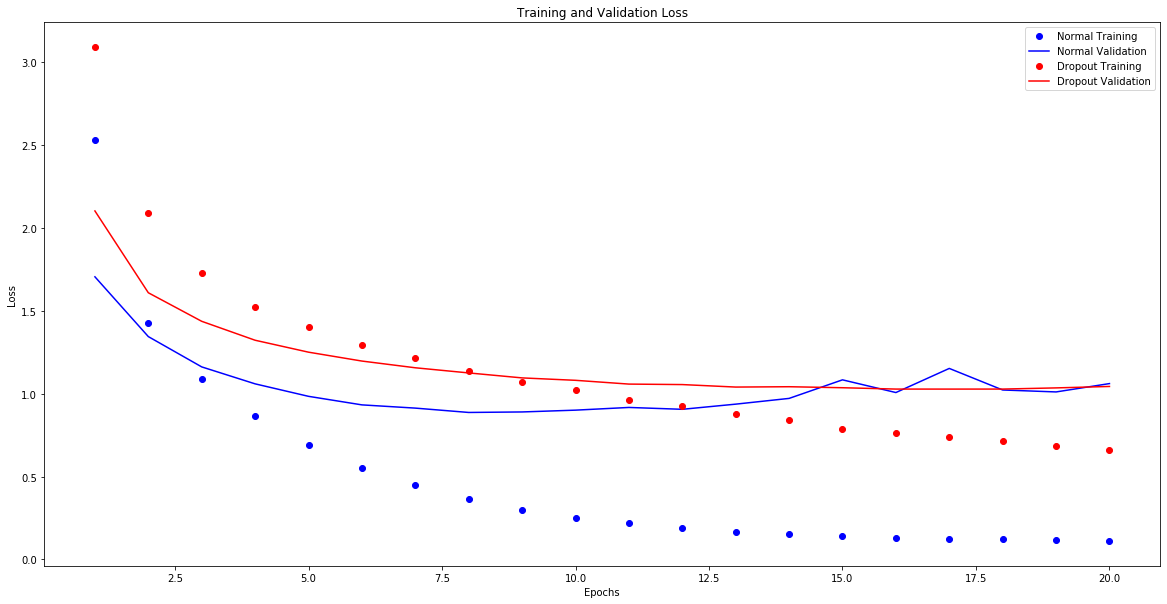

In [8]:
import matplotlib.pyplot as plt

loss = history.history["loss"]
val_loss = history.history["val_loss"]
dropout_loss = dropout_history.history["loss"]
dropout_val_loss = dropout_history.history["val_loss"]

epochs = range(1, len(loss)+1)
plt.figure(figsize=(20,10))
# normal training loss blue dotted
plt.plot(epochs, loss, "bo", label="Normal Training")
# normal validation loss blue solid
plt.plot(epochs, val_loss, "b", label="Normal Validation")
# dropout training loss red dotted
plt.plot(epochs, dropout_loss, "ro", label="Dropout Training")
# dropout validation loss red solid
plt.plot(epochs, dropout_val_loss, "r", label="Dropout Validation")
# title, labels, legend
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

<Figure size 432x288 with 0 Axes>

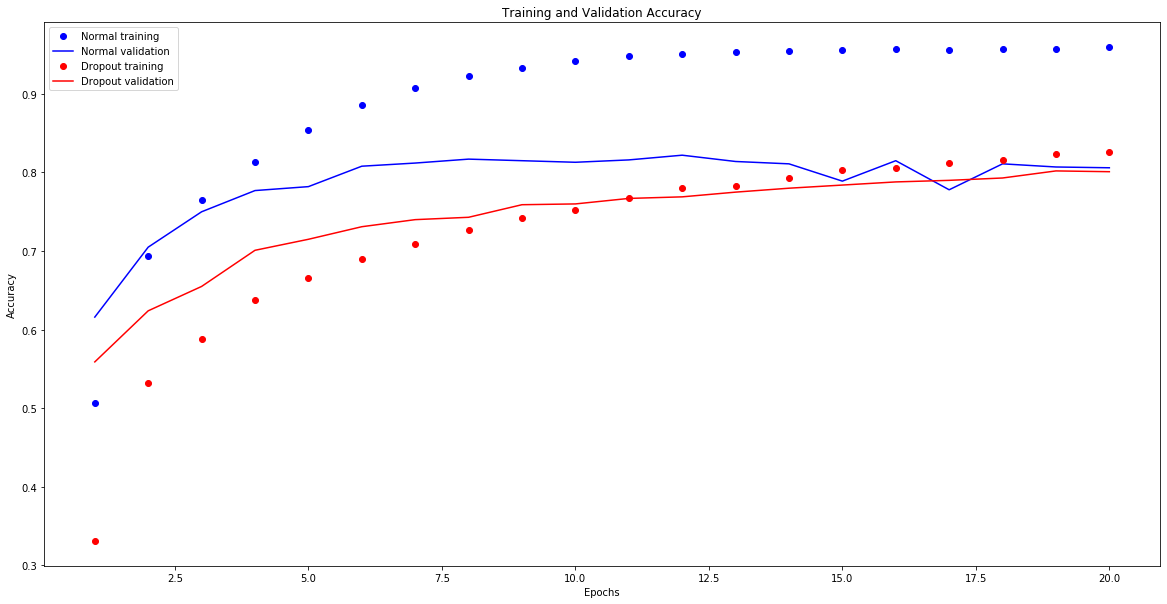

In [9]:
plt.clf()
plt.figure(figsize=(20,10))

acc = history.history["categorical_accuracy"]
val_acc = history.history["val_categorical_accuracy"]
dropout_acc = dropout_history.history["categorical_accuracy"]
dropout_val_acc = dropout_history.history["val_categorical_accuracy"]

# normal training accuracy blue dotted
plt.plot(epochs, acc, "bo", label="Normal training")
# normal validation accuracy blue solid
plt.plot(epochs, val_acc, "b", label="Normal validation")
# dropout training accuracy red dotted
plt.plot(epochs, dropout_acc, "ro", label="Dropout training")
# dropout validation accuracy red solid
plt.plot(epochs, dropout_val_acc, "r", label="Dropout validation")
# title, labels, legend
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

### Evaluate Test Data

In [10]:
normal_results = model.evaluate(x_test, one_hot_test_labels)
dropout_results = dropout_model.evaluate(x_test, one_hot_test_labels)

print("Normal Model: {}".format(normal_results))
print("Dropout Model: {}".format(dropout_results))

2246/2246 [==============================] - 0s 141us/step
Normal Model: [1.2178737425103532, 0.7791629563668745]
Dropout Model: [1.135061059588316, 0.7707034728936818]


#### Generate Predictions on New Data

In [16]:
normal_predictions = model.predict(x_test)
dropout_predictions = dropout_model.predict(x_test)

random_pick = np.random.randint(0, len(x_test)-1)
print("looking at entry: {}".format(random_pick))
print(decode_newswire(test_data[random_pick]))
print("Largest entry (predicted class):")
print("Normal Model: {}".format(np.argmax(normal_predictions[random_pick])))
print("Dropout Model: {}".format(np.argmax(dropout_predictions[random_pick])))


looking at entry: 39
? american brands inc said it expects first quarter net earnings to exceed the record 118 7 mln dlrs or 1 05 dlrs a share it earned for the year ago quarter the company also said it believes sales in the first quarter will ? record sales of 2 1 billion dlrs last year the company said unit sales of american ? lucky strike ? line rose 20 pct last year which led to a gain for he lucky franchise american brands said it will introduce a new low priced brand of cigarettes called ? the company's u k based ? ltd unit had a strong performance in 1986 and became the second largest ? to operating earnings american brands said reuter 3
Largest entry (predicted class):
Normal Model: 3
Dropout Model: 3
